In [40]:
import numpy as np 
import matplotlib.pyplot as plt
import time
from data_utils import load_dataset
from sklearn import neighbors

In [6]:
def l2_dist(x_train, test_point):
    l2 = np.sqrt(np.sum(np.square(x_train-test_point),axis=1))
    return l2

In [7]:
def l1_dist(x_train, test_point):
    l1 = np.sum(abs(x_train-test_point), axis=1)
    return l1

In [8]:
def RMSE(predictions, true_vals):
    return np.sqrt((np.square(predictions - true_vals)).mean())

In [34]:
def knn(Xtest, Ytest, Xtrain, Ytrain, dist,method,k,k_lim,problem_type):
    start = time.time()
    RMSE_mtx = np.zeros((k_lim, 1))
    if method == 'bf': # Brute-force method 
        if k == -1:
            k_min_diff = (0,float('inf'))
            k_axes = []
            predictions = []
            acc_axes = []
            for k in range(1,k_lim):
                total_diff = float(0)
                difference = 0 
                incorrect = 0
                for i in range (0,Xtest.shape[0]):
                    distance = dist(Xtrain,Xtest[i])
                    i_nn = np.argpartition(distance, kth=k)[:k] # getting indices of k nearest neighbours
                    train_pts = Ytrain[i_nn]
                    
                    if problem_type == 'reg':
                        pred = np.sum(train_pts)/float(k) #avg the values 
                        difference = np.subtract(pred ,Ytest[i])
                        total_diff += np.sqrt(np.square(difference))
                        predictions.append(pred)
                    elif problem_type == 'class':
                        curr_pts = []
                        for pt in (train_pts):
                            train_idx = list(pt).index(True)
                            curr_pts.append(train_idx)

                        # Prediction 
                        classes, count = np.unique(np.asarray(curr_pts), return_counts = True)
                        pred = classes[np.argmax(count)]
                        
                        test_pt = list(Ytrain[i]).index(True)
                        if pred != test_pt:
                            incorrect += 1
        
                if problem_type == 'reg':
                    RMSE_mtx[k] = total_diff/float(len(y_test))
                    k_axes.append(k)
                else:
                    acc_axes.append(incorrect/float(Xtest.shape[0]))
                    k_axes.append(k)
                    if incorrect < k_min_diff[1]: 
                        k_min_diff = (k, incorrect)
            if problem_type == 'reg':
                runtime = time.time() - start
                return [k_axes, predictions,RMSE_mtx,runtime]
            else:
                runtime = time.time() - start
                return [k_min_diff, k_axes, acc_axes,runtime]

        elif k!=-1:
            total_diff = float(0)
            predictions = []
            incorrect = 0
            for i in range (0,Xtest.shape[0]):
                distance = dist(Xtrain,Xtest[i])
                i_nn = np.argpartition(distance, kth=k)[:k] # getting indices of k nearest neighbours
                train_pts = Ytrain[i_nn]
                if problem_type == 'reg':
                    pred = np.sum(train_pts)/float(k)
                    difference = np.subtract(pred ,Ytest[i])
                    total_diff += np.sqrt(np.square(difference))
                    
                    predictions.append(pred)
                else:
                    curr_pts = []
                    for pt in (train_pts):
                        train_idx = list(pt).index(True)
                        curr_pts.append(train_idx)

                    # Prediction 
                    classes, count = np.unique(np.asarray(curr_pts), return_counts = True)
                    pred = classes[np.argmax(count)]

                    test_pt = list(Ytrain[i]).index(True)
                    if pred != test_pt:
                        incorrect += 1
            if problem_type == 'reg':
                RMSE = total_diff/float(len(Ytest))
                runtime = time.time() - start
                return [RMSE, runtime]
            else:
                accuracy = incorrect/float(Ytest.shape[0])
                runtime = time.time() - start
                return [accuracy,runtime]

    elif method == 'd': #KDTree Method
        kdt = neighbors.KDTree(x_train)
        d, i_nn = kdt.query(x_test, k=k, return_distance = True)
        preds = np.sum(y_train[i_nn], axis=1)/float(k)
        RMSE = (np.sqrt(np.square(np.subtract(preds ,y_test))))/float(len(y_test))
        
        runtime = time.time() - start
        return [(np.sum(RMSE,axis=0)), runtime]
        


In [10]:
def plot_RMSE_kestimate(x_valid, y_valid, x_train, y_train,klim):
    k_axes_1_l1, predictions_1_l1, RMSE_1_l1,runtime = knn(x_valid, y_valid, x_train, y_train, l1_dist,'bf',-1,klim,'reg')
    k_axes_1_l1, predictions_1_l1, RMSE_1_l2,runtime = knn(x_valid, y_valid, x_train, y_train, l2_dist,'bf',-1,klim,'reg')
    print('Estimate of k for l1 dist metric :', np.argmin(RMSE_1_l1[1:]))
    print('Estimate of k for l2 dist metric :', np.argmin(RMSE_1_l2[1:]))

    plt.title('Estimate of k')
    plt.xlabel('k')
    plt.ylabel('RMSE loss')

    plt.plot(RMSE_1_l1[1:],label='l1')
    plt.plot(RMSE_1_l2[1:],label='l2')

    plt.legend(frameon=False)
    return [np.argmin(RMSE_1_l1[1:]),np.argmin(RMSE_1_l2[1:])]

In [11]:
# Cross-Validation 
def cross_val(x_valid,x_train,y_valid, y_train,k_estimate,klim,dist,data):
    x_train_combined = np.vstack([x_valid, x_train])
    y_train_combined = np.vstack([y_valid, y_train])

    X_train_folds = np.array_split(x_train_combined, 5)
    y_train_folds = np.array_split(y_train_combined, 5)

    pred_mtx = []
#     total_RMSE = [None]*5
    total_RMSE = np.zeros(((klim),5))

    for i in range(5):
        training_data, test_data = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:]), X_train_folds[i]
        training_labels, test_labels = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:]), y_train_folds[i]
        if k_estimate == -1:
            k_axes, predictions_1, RMSE_mtx,runtime = knn(test_data, test_labels, training_data, training_labels, dist,'bf',k_estimate,klim,'reg')
    #         pred_mtx += (predictions_1)
    #         total_RMSE += np.sum(RMSE_mtx,axis=0)
            RMSE_mtx.resize((RMSE_mtx.shape[0],))
            total_RMSE[:RMSE_mtx.shape[0],i] = RMSE_mtx
        
        elif k_estimate!= -1:
            predictions_1, RMSE_mtx,runtime = knn(test_data, test_labels, training_data, training_labels, dist,'bf',k_estimate,klim,'reg')
        #     print(len(predictions_1), pred_mtx.shape,test_data.shape)
        #     pred_mtx[:test_data.shape[0],i] = predictions_1 ####bug 
        #     pred_mtx[:test_data.shape[0]]
            pred_mtx += (predictions_1)
#             total_RMSE += np.sum(RMSE_1_l1,axis=0)
            RMSE_mtx.resize((RMSE_mtx.shape[0],))
            total_RMSE[:RMSE_mtx.shape[0],i] = RMSE_mtx
#             total_RMSE += np.sum(RMSE_1_l1,axis=0)
    RMSE = (np.sum(np.asarray(total_RMSE),axis=1)/5.0)
    cross_val_RMSE = np.sum(RMSE[1:],axis=0)/float(RMSE[1:].shape[0])
    print('Distance metric:', dist)
    print('Overall Cross-Validation RMSE:', cross_val_RMSE)
    print('k estimate:', np.argmin(RMSE[1:]))
    if data == 'mauna_loa' and k_estimate != -1:        
        
        
#         plt.figure(1)
#         plt.plot(x_train_combined,pred_mtx,label='Cross-val prediction')
#         plt.plot(x_train_combined, y_train_combined,label='True values')
#         plt.legend(frameon=False)  
        
        return [x_train_combined,pred_mtx,y_train_combined, RMSE]
        
    return [np.argmin(RMSE[1:]),cross_val_RMSE]


## Q1 Objectives
1. Compute nearest neighbours using a brute-force approach. (Done) 
2. Implement the k-NN algorithm for regression with two different distance metrics (l1, l2) --done
3. Use 5-fold cross-validation to estimate k 
4. Choose the preferred distance metric using a root-mean-square error (RMSE) loss. 
5. Apply your algorithm to all regression datasets (use n train=1000, d=2 for rosenbrock). For each dataset, report: estimated of k, the preferred distance metric, the cross-validation RMSE, test RMSE 
6. Format these results in a table.
7. Plot the cross-validation prediction curves for mauna loa at several values of k for the l2 distance metric. 
8. Plot the prediction on the test set, as well as the cross-validation loss across k for this model. 
9. Discuss your results.

# Rosenbrock dataset

In [12]:
from data_utils import load_dataset
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=5000, d=2)
k_lim = int(np.ceil(np.sqrt(x_test.shape[0])))

In [13]:
k_estimate_l1, RMSE_l1 = cross_val(x_valid,x_train,y_valid,y_train,-1,k_lim,l1_dist,'rosen')

Distance metric: <function l1_dist at 0x7f4368eb7560>
Overall Cross-Validation RMSE: 0.07328506607387043
k estimate: 3


In [14]:
k_estimate_l2, RMSE_l2 = cross_val(x_valid,x_train,y_valid,y_train,-1,k_lim,l2_dist,'rosen')

Distance metric: <function l2_dist at 0x7f4368eb7b90>
Overall Cross-Validation RMSE: 0.07250036612847191
k estimate: 3


In [15]:
if RMSE_l2 <= RMSE_l1:
    RMSE_best = RMSE_l2
    dist = l2_dist
    k_estimate = k_estimate_l2
else:
    RMSE_best = RMSE_l1
    dist = l1_dist
    k_estimate = k_estimate_l1
print('Rosenbrock dataset')

print('Estimated k for Rosenbrock:', k_estimate)
print('Preferred distance metric for Rosenbrock:', str(dist))
predictions, RMSE,runtime = knn(x_test, y_test, x_train, y_train, dist,'bf',k_estimate,k_lim,'reg')
print('Overall Test RMSE:', (np.sum(RMSE,axis=0)/5.0))
print('Overall Cross-Validation RMSE:', RMSE_best)


Rosenbrock dataset
Estimated k for Rosenbrock: 3
Preferred distance metric for Rosenbrock: <function l2_dist at 0x7f4368eb7b90>
Overall Test RMSE: 0.01682180242233699
Overall Cross-Validation RMSE: 0.07250036612847191


# pumadyn32nm dataset

In [16]:
from data_utils import load_dataset
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')
k_lim = int(np.ceil(np.sqrt(x_test.shape[0])))

In [17]:
k_estimate_l1, RMSE_l1 = cross_val(x_valid,x_train,y_valid,y_train,-1,k_lim,l1_dist,'pumadyn')

Distance metric: <function l1_dist at 0x7f4368eb7560>
Overall Cross-Validation RMSE: 1.276928900426728
k estimate: 27


In [18]:
k_estimate_l2, RMSE_l2 = cross_val(x_valid,x_train,y_valid,y_train,-1,k_lim,l2_dist,'pumadyn')

Distance metric: <function l2_dist at 0x7f4368eb7b90>
Overall Cross-Validation RMSE: 1.3125363419330462
k estimate: 18


In [19]:
if RMSE_l2 <= RMSE_l1:
    RMSE_best = RMSE_l2
    dist = l2_dist
    k_estimate = k_estimate_l2
else:
    RMSE_best = RMSE_l1
    dist = l1_dist
    k_estimate = k_estimate_l1
print('pumadyn32nm dataset')

print('Estimated k for pumadyn32nm:', k_estimate)
print('Preferred distance metric for pumadyn32nm:', str(dist))
predictions, RMSE,runtime = knn(x_test, y_test, x_train, y_train, dist,'bf',k_estimate,k_lim,'reg')
print('Overall Test RMSE:', (np.sum(RMSE,axis=0)/5.0))
print('Overall Cross-Validation RMSE:', RMSE_best)

pumadyn32nm dataset
Estimated k for pumadyn32nm: 27
Preferred distance metric for pumadyn32nm: <function l1_dist at 0x7f4368eb7560>
Overall Test RMSE: 0.13278341243442296
Overall Cross-Validation RMSE: 1.276928900426728


## Mauna_loa dataset 

In [20]:
from data_utils import load_dataset
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
# estimate_mauna_l1, estimate_mauna_l2= plot_RMSE_kestimate(x_valid, y_valid, x_train, y_train,(x_valid.shape[0]))
k_lim = x_test.shape[0]
print(x_train.shape, x_test.shape, x_valid.shape,'\n', y_train.shape, y_test.shape,y_valid.shape)

(511, 1) (73, 1) (145, 1) 
 (511, 1) (73, 1) (145, 1)


In [21]:
k_estimate_l1, RMSE_l1 = cross_val(x_valid,x_train,y_valid,y_train,-1,k_lim,l1_dist,'mauna_loa')

Distance metric: <function l1_dist at 0x7f4368eb7560>
Overall Cross-Validation RMSE: 0.47694309898175974
k estimate: 10


In [22]:
k_estimate_l2, RMSE_l2 = cross_val(x_valid,x_train,y_valid,y_train,-1,k_lim,l2_dist,'mauna_loa')

Distance metric: <function l2_dist at 0x7f4368eb7b90>
Overall Cross-Validation RMSE: 0.47694309898175974
k estimate: 10


In [23]:
if RMSE_l2 <= RMSE_l1:
    RMSE_best = RMSE_l2
    dist = l2_dist
    k_estimate = k_estimate_l2
else:
    RMSE_best = RMSE_l1
    dist = l1_dist
    k_estimate = k_estimate_l1
print('Mauna_loa dataset')

print('Estimated k for mauna_loa:', k_estimate)
print('Preferred distance metric for mauna_loa:', str(dist))
predictions, RMSE,runtime = knn(x_test, y_test, x_train, y_train, dist,'bf',k_estimate,k_lim,'reg')
print('Overall Test RMSE:', (np.sum(RMSE,axis=0)/5.0))
print('Overall Cross-Validation RMSE:', RMSE_best)

Mauna_loa dataset
Estimated k for mauna_loa: 10
Preferred distance metric for mauna_loa: <function l2_dist at 0x7f4368eb7b90>
Overall Test RMSE: 0.060811079298245474
Overall Cross-Validation RMSE: 0.47694309898175974


Overall Test RMSE: 0.060811079298245474


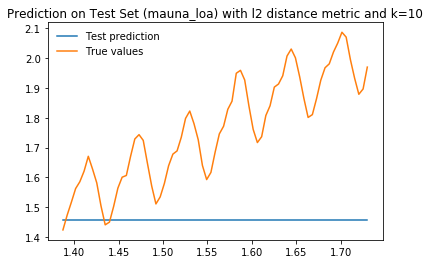

In [24]:
## Plotting prediction on test set 
predictions, RMSE,runtime = knn(x_test, y_test, x_train, y_train, dist,'bf',k_estimate, k_lim,'reg')
print('Overall Test RMSE:', (np.sum(RMSE,axis=0)/5.0))
plt.title('Prediction on Test Set (mauna_loa) with l2 distance metric and k=10')
plt.plot( x_test,predictions,label='Test prediction')
plt.plot( x_test, y_test,label='True values')
plt.legend(frameon=False)

10 73 <function l2_dist at 0x7f4368eb7b90>
Distance metric: <function l2_dist at 0x7f4368eb7b90>
Overall Cross-Validation RMSE: 0.0
k estimate: 0


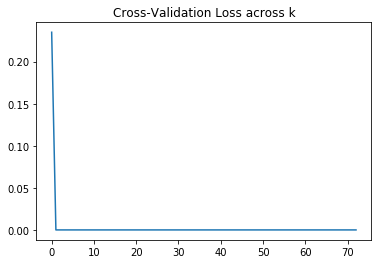

In [25]:
## Plotting cross-validation loss across k 
print(k_estimate, k_lim, dist)
x_train_combined,pred_mtx,y_train_combined, RMSE = cross_val(x_valid,x_train,y_valid,y_train,k_estimate,k_lim,l2_dist,'mauna_loa')

plt.figure(0)
plt.title('Cross-Validation Loss across k')
plt.plot(RMSE)


10
Distance metric: <function l2_dist at 0x7f4368eb7b90>
Overall Cross-Validation RMSE: 0.0
k estimate: 0
Distance metric: <function l2_dist at 0x7f4368eb7b90>
Overall Cross-Validation RMSE: 0.0
k estimate: 0
Distance metric: <function l2_dist at 0x7f4368eb7b90>
Overall Cross-Validation RMSE: 0.0
k estimate: 0
Distance metric: <function l2_dist at 0x7f4368eb7b90>
Overall Cross-Validation RMSE: 0.0
k estimate: 0


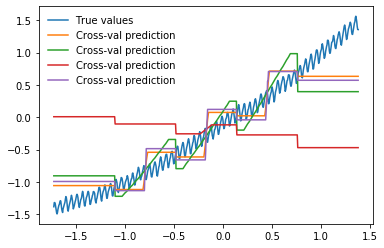

In [26]:
## Plotting cross-validation prediction curves
print(k_estimate)
k_tries = [k_estimate, k_estimate*10, k_estimate*50, 5]

plt.figure(1)
plt.plot(x_train_combined, y_train_combined,label='True values')

for k_try in k_tries:
    x_train_combined,pred_mtx,y_train_combined, RMSE = cross_val(x_valid,x_train,y_valid,y_train,k_try,k_lim,l2_dist,'mauna_loa')
    plt.plot(x_train_combined,pred_mtx,label='Cross-val prediction') ### Fix label
    plt.legend(frameon=False)

## Q2 Objectives
1. Implement the k-NN algorithm for classification with two different distance metrics
2. Estimate k and the preferred distance metric by maximizing the accuracy (fraction of correct predictions) on the validation split
3. Apply your algorithm to all classification datasets. For each dataset, report: estimated k, the preferred distance metric, the validation accuracy and test accuracy
4. Format these results in a table.

In [27]:
# Load Data
# Note: Data provided is already scaled to zero mean and unit variance (no scaling/normalization necessary)

from data_utils import load_dataset
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
# x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
# k_lim = int(np.ceil(np.sqrt(x_test.shape[0])))
k_lim = x_train.shape[0]
print(x_train.shape, x_test.shape, x_valid.shape,'\n', y_train.shape, y_test.shape,y_valid.shape )

(104, 4) (15, 4) (31, 4) 
 (104, 3) (15, 3) (31, 3)


## Iris dataset


Iris set
k estimate: 6
Preferred: l1 distance metric
Validation Accuracy: 0.6918258690886312
Test Accuracy: 0.5333333333333333


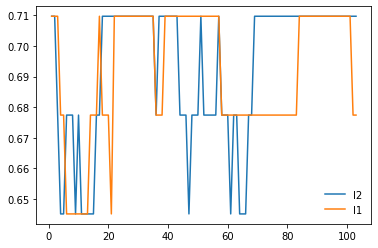

In [30]:
# Validation Accuracy 

k_min_diff2, k_axes2, acc_axes2,runtime = knn(x_valid,y_valid,x_train,y_train,l2_dist,'bf',-1,k_lim,'class')
k_min_diff4, k_axes4, acc_axes4,runtime = knn(x_valid,y_valid,x_train,y_train,l1_dist,'bf',-1,k_lim,'class')
accuracy_l2 = np.sum(np.asarray(acc_axes2),axis=0)/float(len(acc_axes2))
accuracy_l1 = np.sum(np.asarray(acc_axes4),axis=0)/float(len(acc_axes4))

if accuracy_l2 <= accuracy_l1:
    preferred = 'l2 distance metric'
    dist_pref = l2_dist
    k_estimate = k_min_diff2[0]
    acc = accuracy_l2
else:
    preferred = 'l1 distance metric'
    dist_pref = l1_dist
    k_estimate = k_min_diff4[0]
    acc = accuracy_l1

print('Iris set')

print('k estimate:', k_estimate)
print('Preferred:', preferred)
print('Validation Accuracy:', acc)

# Test Accuracy 

test_acc,runtime = knn(x_test,y_test,x_train,y_train,dist_pref,'bf',k_estimate,k_lim,'class')
print('Test Accuracy:', test_acc)

# plt.title('')
plt.plot(k_axes2,acc_axes2,label='l2')
plt.plot(k_axes4,acc_axes4,label='l1')

plt.legend(frameon=False)

## mnist dataset

In [31]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
k_lim = int(np.ceil(np.sqrt(x_test.shape[0])))

Iris set
k estimate: 26
Preferred: l1 distance metric
Validation Accuracy: 0.8979677419354839
Test Accuracy: 0.903


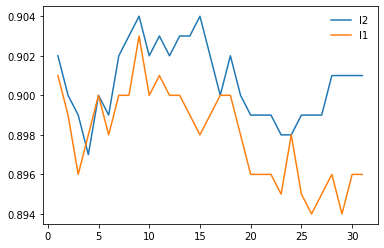

In [32]:
# Validation Accuracy 

k_min_diff2, k_axes2, acc_axes2,runtime = knn(x_valid,y_valid,x_train,y_train,l2_dist,'bf',-1,k_lim,'class')
k_min_diff4, k_axes4, acc_axes4,runtime = knn(x_valid,y_valid,x_train,y_train,l1_dist,'bf',-1,k_lim,'class')
accuracy_l2 = np.sum(np.asarray(acc_axes2),axis=0)/float(len(acc_axes2))
accuracy_l1 = np.sum(np.asarray(acc_axes4),axis=0)/float(len(acc_axes4))

if accuracy_l2 <= accuracy_l1:
    preferred = 'l2 distance metric'
    dist_pref = l2_dist
    k_estimate = k_min_diff2[0]
    acc = accuracy_l2
else:
    preferred = 'l1 distance metric'
    dist_pref = l1_dist
    k_estimate = k_min_diff4[0]
    acc = accuracy_l1

print('Iris set')

print('k estimate:', k_estimate)
print('Preferred:', preferred)
print('Validation Accuracy:', acc)

# Test Accuracy 

test_acc,runtime = knn(x_test,y_test,x_train,y_train,dist_pref,'bf',k_estimate,k_lim,'class')
print('Test Accuracy:', test_acc)

# plt.title('')
plt.plot(k_axes2,acc_axes2,label='l2')
plt.plot(k_axes4,acc_axes4,label='l1')

plt.legend(frameon=False)

## Q3 Objectives
1. Test the performance of your k-NN regression algorithm with a k-d tree data structure
2. Conduct performance studies by making predictions on the test set of the rosenbrock regression dataset with n train=5000. Report the run-time for varying values of d in a single plot. Use the l2 distance metric and k = 5.
3. Comment on the relativeperformance of the k-d tree algorithm versus the brute-force approach implemented while answering Q1 and Q2. 
4. Use the time.time function to measure elapsed wall-clock time. 

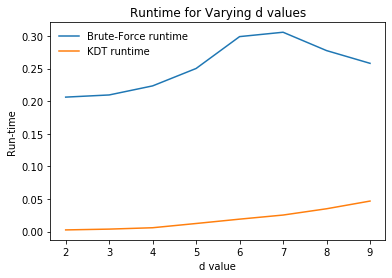

In [37]:
d_vals = np.arange(2,10)
bf_runtime_total = []
d_runtime_total = []

from data_utils import load_dataset

for val in d_vals:
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=5000, d=val)
    bf_RMSE, bf_runtime = knn(x_test, y_test, x_train, y_train, l2_dist,'bf',5,int(np.ceil(np.sqrt(x_test.shape[0]))),'reg')
    d_RMSE, d_runtime = knn(x_test, y_test, x_train, y_train, l2_dist,'d',5,int(np.ceil(np.sqrt(x_test.shape[0]))),'reg')
    bf_runtime_total.append(bf_runtime)
    d_runtime_total.append(d_runtime)

plt.title('Runtime for Varying d values')
plt.plot(d_vals, bf_runtime_total, label = 'Brute-Force runtime')
plt.plot(d_vals, d_runtime_total, label = 'KDT runtime')
plt.xlabel ('d value')
plt.ylabel ('Run-time')
plt.legend(frameon=False)    

## Q4 Objectives
1. Implement a linear regression algorithm that minimizes the least-squares loss function (using the SVD) and apply to all datasets (regression and classification).
2. Use both the training and validation sets to predict on the test set, and format your results in a table (present test RMSE for regression, and test accuracy for classification).
3. Compare the performance of this method to the k-NN algorithm.

In [38]:
def lin_reg(x_train, x_valid, x_test, y_train, y_valid, y_test, model):
    x_combined = np.vstack([x_train, x_valid])
    y_combined = np.vstack([y_train, y_valid])

    X = np.zeros(((x_combined.shape[0]), (x_combined.shape[1]) + 1))
    X[:, 1:] = x_combined
    total_diff = 0 

    # Compute SVD
    u, s, vh = np.linalg.svd(X)


    #V1 
#         sigma = np.zeros(X.shape)
#         sigma[:X.shape[1], :X.shape[1]] = np.diag(s)
#         sigma_pinv = vh.T.dot(sigma.T).dot(u.T)

    #V2 
    sigma = np.diag(s)
    dummy = np.zeros([len(x_combined)-len(s), len(s)])
    sigma_pinv = np.linalg.pinv(np.vstack([sigma, dummy]))

    # Compute weights 
    w = np.dot(vh.T, np.dot(sigma_pinv, np.dot(u.T, y_combined)))

    X_test = np.zeros(((x_test.shape[0]), (x_test.shape[1]) + 1))
    X_test[:, 1:] = x_test
    
    if model == 'reg':
        # Calculate prediction RMSE
        preds = np.dot(X_test, w)
        difference = np.subtract(preds ,y_test)
        total_diff += np.sqrt(np.square(difference))
        RMSE = total_diff/float(len(y_test))
        return np.sum(RMSE,axis=0)
        
    elif model == 'class':
        # Calculate prediction accuracy
        preds = np.argmax(np.dot(X_test, w), axis=1)
        y_test = np.argmax((y_test), axis=1)
        return ((preds == y_test).sum()/float(len(y_test)))

In [39]:
from data_utils import load_dataset
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
result = lin_reg(x_train, x_valid, x_test, y_train, y_valid, y_test, 'reg')
print('Test RMSE for mauna_loa:' ,result[0])

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=5000, d=2)
result = lin_reg(x_train, x_valid, x_test, y_train, y_valid, y_test, 'reg')
print('Test RMSE for rosenbrock:' ,result[0])

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')
result = lin_reg(x_train, x_valid, x_test, y_train, y_valid, y_test, 'reg')
print('Test RMSE for pumadyn32nm:' ,result[0])

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
result = lin_reg(x_train, x_valid, x_test, y_train, y_valid, y_test, 'class')
print('Classification accuracy for iris:' ,result)

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
result = lin_reg(x_train, x_valid, x_test, y_train, y_valid, y_test, 'class')
print('Classification accuracy for mnist_small:' ,result)

Test RMSE for mauna_loa: 0.28972668720017775
Test RMSE for rosenbrock: 0.4920845447935378
Test RMSE for pumadyn32nm: 0.67992525600153
Classification accuracy for iris: 0.8666666666666667
Classification accuracy for mnist_small: 0.857
